# Mask R-CNN - Inspect Ballon Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.balloon import seal

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
SEAL_WEIGHTS_PATH = "mask_rcnn_seal_0030.h5"  # TODO: update this path



for path in sys.path:
    if os.path.exists(os.path.join(path, 'mrcnn')):
        
        print('some_module is here: {}'.format(path))

some_module is here: /media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master
some_module is here: /media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master


Using TensorFlow backend.


In [2]:
from samples.balloon import seal

## Configurations

In [3]:
config = seal.SealConfig()
SEAL_DIR = os.path.join(ROOT_DIR, "datasets/seal")

In [4]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [7]:
# Load validation dataset
dataset = seal.SealDataset()
dataset.load_seal(SEAL_DIR, "test")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

[{'region_attributes': {}, 'shape_attributes': {'cx': 677, 'r': 114, 'cy': 1256, 'name': 'circle'}}]
Images: 306
Classes: ['BG', 'seal']


In [8]:
image = dataset.load_image_seal(2)
image

/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img2-3-83.jpg


'/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img2-3-83.jpg'

In [20]:
aa='/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img2-3-83.jpg'
aa = aa.split('/')
aa = aa[-1:]
print(aa[0])

img2-3-83.jpg


## Load Model

In [9]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [10]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/logs/seal20200422T1140/mask_rcnn_seal_0030.h5
Re-starting from epoch 30


In [9]:
def postChecking(masks, rois):
    masks = masks[rois[0]:rois[2],rois[1]:rois[3]]
    masks=masks.reshape(masks.shape[0], masks.shape[1], 1)
    ###################################################
    ideal_seal = np.zeros((masks.shape[0],masks.shape[1]),  dtype=bool)
    ideal_seal = ideal_seal.reshape(masks.shape[0],masks.shape[1],1)
    for i in range(len(ideal_seal)):
        for j in range(len(ideal_seal[i])):
            if np.sqrt(pow((len(masks[0])/2-i),2)+pow((len(masks[0])/2-j),2))<=len(masks[0])/2:
                ideal_seal[i][j]=True
    res = np.subtract(ideal_seal, masks, dtype=np.int)
    count=0
    for i, el in enumerate(res):
        for j in el:
            if j!=0:
                count+=1
    shape_arr = masks.shape[0]*masks.shape[1]*masks.shape[2]
    res_perc = count*100/shape_arr
    if res_perc<13:
        return True
    else:
        return False

## Run Detection

image ID: seal.p2_apostille-Yakutsk.jfif (136) /media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/p2_apostille-Yakutsk.jfif
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[[ 625  124  956  457]
 [ 867  431 1024  597]] [0.99770856 0.9803233 ]
1024


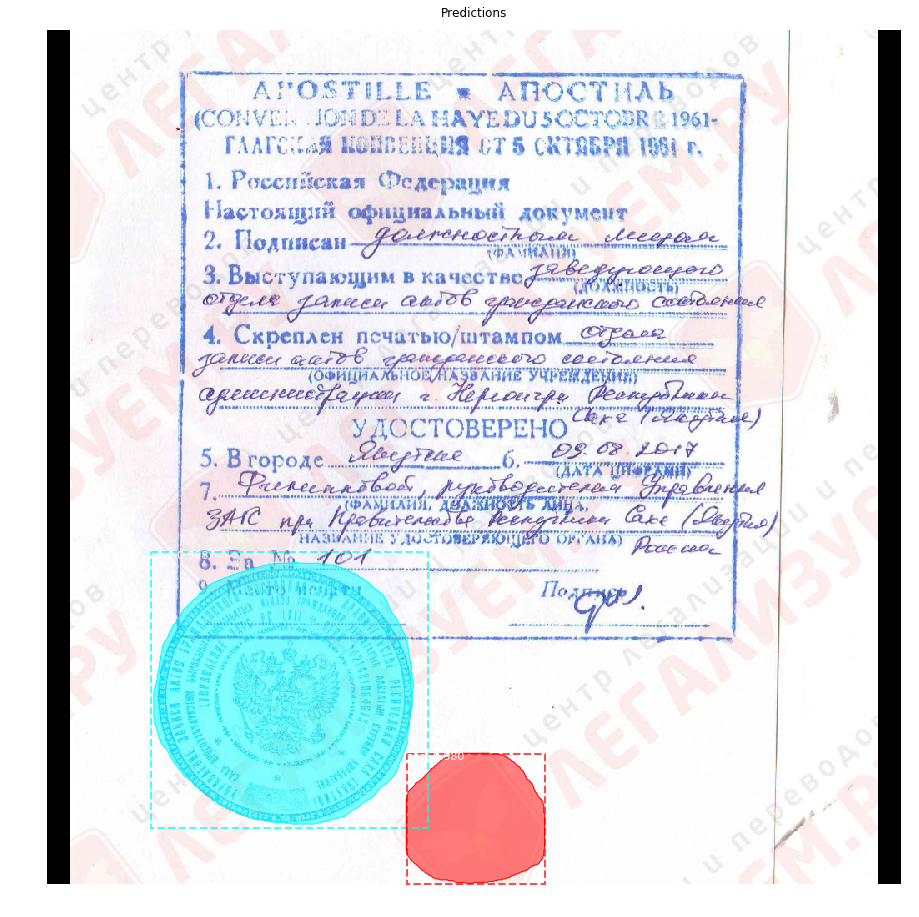

In [11]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
#import matplotlib.image as mpimg
#image=mpimg.imread('1-004.jpg')


# Run object detection
results = model.detect([image], verbose=1)

# Display results

ax = get_ax(1)
r = results[0]

#res = postChecking(r['masks'], r['rois'][0])
#print(res)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
print(r['rois'], r['scores'])
print(len(r['masks']))
#import cv2 
#cv2.imwrite("1.jpg", image[253:566, 800:1117])
#mpimg.imsave("2.jpg", image[253:566, 800:1117])
#plt.savefig("1.jpg", r['masks'])
#log("gt_class_id", gt_class_id)
#log("gt_bbox", gt_bbox)
#log("gt_mask", gt_mask)


In [22]:
print(gt_bbox)
#print(results)

[[510 651 676 818]]


[1.  1.  0.5 0. ] [0. 1. 1. 1.]


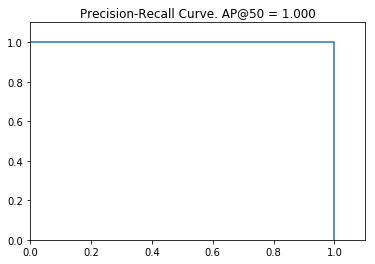

In [12]:
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
print(precisions, recalls)
visualize.plot_precision_recall(AP, precisions, recalls)

In [58]:
def compute_batch_ap(image_ids):
    APs = []
    gt_boxes ={}
    pred_boxes={}
    for image_id in image_ids:
       
        # Load image
        try:
            img_name = dataset.load_image_seal(image_id)
            img_name = img_name.split('/')
            img_name = img_name[-1:]
            img_name = img_name[0]
            image, image_meta, gt_class_id, gt_bbox, gt_mask =\
                modellib.load_image_gt(dataset, config,
                                       image_id, use_mini_mask=False)

            #print(image_id)
            # Run object detection
            results = model.detect([image], verbose=0)
            # Compute AP
            r = results[0]





            AP, precisions, recalls, overlaps =\
                utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                  r['rois'], r['class_ids'], r['scores'], r['masks'])
            #print("AVGprecisions: {}, precisions: {}, recalls:{}".format( AP, precisions, recalls))
            APs.append(AP)
            pr_b = {}
            gt_boxes[img_name] = gt_bbox
            pr_b['boxes']=r['rois'].tolist()
            pr_b['scores']=r['scores'].tolist()
            pred_boxes[img_name] = pr_b
        except:
            continue
        
    return APs, gt_boxes, pred_boxes

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 306)
APs,gt_boxes, pred_boxes   = compute_batch_ap(image_ids)
print(len(APs))
print("mAP @ IoU=50: ", np.mean(APs))


/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img3-4-37.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/blago_korobeynikov.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img2-3-77.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/unnamed (33).jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img-5-20.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img3-2-100.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img2-0-11.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/edss_reutov.jpg
/m

/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img3-1-153.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/p2_Trud-1024x559.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img3-6-48.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img3-1-143.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img2-0-11.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/bassein-1.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img3-0-106.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img2-3-50.jpg
/media

/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/p2_2b59b741149f.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/p2_kopiya-titulnogo-lista.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/p2_apostil-dokumentov-v-minske.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img3-0-105.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img-3-1.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/p2_НЗП-2018.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img3-7-84.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datas

/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/p2_цкуц.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img-3-31.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img3-4-86.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img2-4-13.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/p2_unnamed.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/1408600875_33641592.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img2-3-143.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img-3-39.jpg
/media/m

/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img-3-68.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img-2-28.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img-2-28.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/ip-bylo-stalo.png
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img3-16-17.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/p2_images (24).jfif
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img3-1-69.jpg
/media/manapov/7ff2a4aa-26aa-48f8-ae2a-9fba42bc53431/Work/seal-detection/Mask_RCNN-master/datasets/seal/test/img3-3-70.jpg
/media/m

In [23]:
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [24]:
def get_model_scores(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_score={}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_score.keys():
                model_score[score]=[img_id]
            else:
                model_score[score].append(img_id)
    return model_score

In [25]:
r['rois']

array([[ 625,  124,  956,  457],
       [ 867,  431, 1024,  597]], dtype=int32)

In [26]:
def calc_iou( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [71]:
def calc_precision_recall(image_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_positive=0
    false_positive=0
    false_negative=0
    for img_id, res in image_results.items():
        true_positive +=res['true_positive']
        false_positive += res['false_positive']
        false_negative += res['false_negative']
        try:
            precision = true_positive/(true_positive+ false_positive)
        except ZeroDivisionError:
            precision=0.0
        try:
            recall = true_positive/(true_positive + false_negative)
        except ZeroDivisionError:
            recall=0.0
    print(precisions, recall)        
    return (precision, recall)

In [28]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

In [78]:
def  get_avg_precision_at_iou(gt_boxes, pred_bb, iou_thr=0.75):
    
    model_scores = get_model_scores(pred_bb)
    sorted_model_scores= sorted(model_scores.keys())
# Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_bb.keys():
        
        arg_sort = np.argsort(pred_bb[img_id]['scores'])
        pred_bb[img_id]['scores'] = np.array(pred_bb[img_id]['scores'])[arg_sort].tolist()
        pred_bb[img_id]['boxes'] = np.array(pred_bb[img_id]['boxes'])[arg_sort].tolist()
        
        pred_boxes_pruned = deepcopy(pred_bb)
    
    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
# Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
            # On first iteration, define img_results for the first time:
        #print("Mode score : ", model_score_thr)
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores[model_score_thr]
        for img_id in img_ids:
               
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break 
            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores']= pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes']= pred_boxes_pruned[img_id]['boxes'][start_idx:]
# Recalculate image results for this image
            #print(img_id)
            img_results[img_id] = get_single_image_results(gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr=0.5)
# calculate precision and recall
        print("-----------------------------------------")
        print(len(img_results))
        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args= np.argwhere(recalls>recall_level).flatten()
            prec= max(precisions[args])
            #print(recalls,"Recall")
            #print(      recall_level,"Recall Level")
            #print(       args, "Args")
            #print(       prec, "precision")
        except ValueError:
            prec=0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec) 
    print(np.mean(precisions))
    print(np.mean(recalls))
    print(avg_prec)
    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

In [84]:
len(gt_boxes)

189

In [79]:
get_avg = get_avg_precision_at_iou(gt_boxes, pred_boxes)

-----------------------------------------
189
[1.  1.  0.5 0. ] 0.9951690821256038
-----------------------------------------
189
[1.  1.  0.5 0. ] 0.9951690821256038
-----------------------------------------
189
[1.  1.  0.5 0. ] 0.9951690821256038
-----------------------------------------
189
[1.  1.  0.5 0. ] 0.9951690821256038
-----------------------------------------
189
[1.  1.  0.5 0. ] 0.9951690821256038
-----------------------------------------
189
[1.  1.  0.5 0. ] 0.9951690821256038
-----------------------------------------
189
[1.  1.  0.5 0. ] 0.9951456310679612
-----------------------------------------
189
[1.  1.  0.5 0. ] 0.9951456310679612
-----------------------------------------
189
[1.  1.  0.5 0. ] 0.9951456310679612
-----------------------------------------
189
[1.  1.  0.5 0. ] 0.9951456310679612
-----------------------------------------
189
[1.  1.  0.5 0. ] 0.9951456310679612
-----------------------------------------
189
[1.  1.  0.5 0. ] 0.9951456310679612
----

Text(0.5,1,'Average precision score, micro-averaged over all classes: AP=0.91')

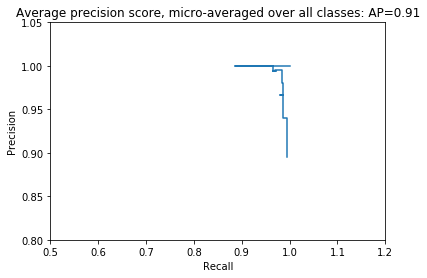

In [60]:
plt.figure()
plt.step(get_avg['recalls'], get_avg['precisions'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.8, 1.05])
plt.xlim([0.5, 1.2])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(get_avg["avg_prec"]))

Text(0.5,1,'Average precision score: AP=0.91')

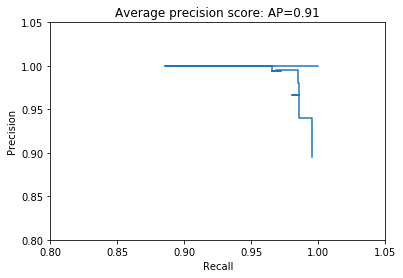

In [83]:
#ioU 75
plt.figure()
plt.step(get_avg['recalls'], get_avg['precisions'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.8, 1.05])
plt.xlim([0.8, 1.05])
plt.title(
    'Average precision score: AP={0:0.2f}'
    .format(get_avg["avg_prec"]))

In [1]:
len(get_avg['recalls'])

NameError: name 'get_avg' is not defined

## Color Splash

This is for illustration. You can call `balloon.py` with the `splash` option to get better images without the black padding.

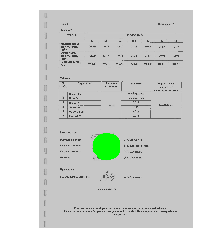

In [21]:
import cv2
splashs = seal.color_splash2(image, results)
#print(splash)
for splash in splashs:
    plt.imshow(splash)
    plt.axis("off")
    plt.show()

#cv2.imshow("1", splash)


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [17]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -1.05469  max:    0.78125  float64
positive_anchors         shape: (4, 4)                min:  112.00000  max:  624.00000  float64
negative_anchors         shape: (252, 4)              min:  -48.00000  max: 1061.25483  float64
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (4, 4)                min:  108.00000  max:  624.00000  float32


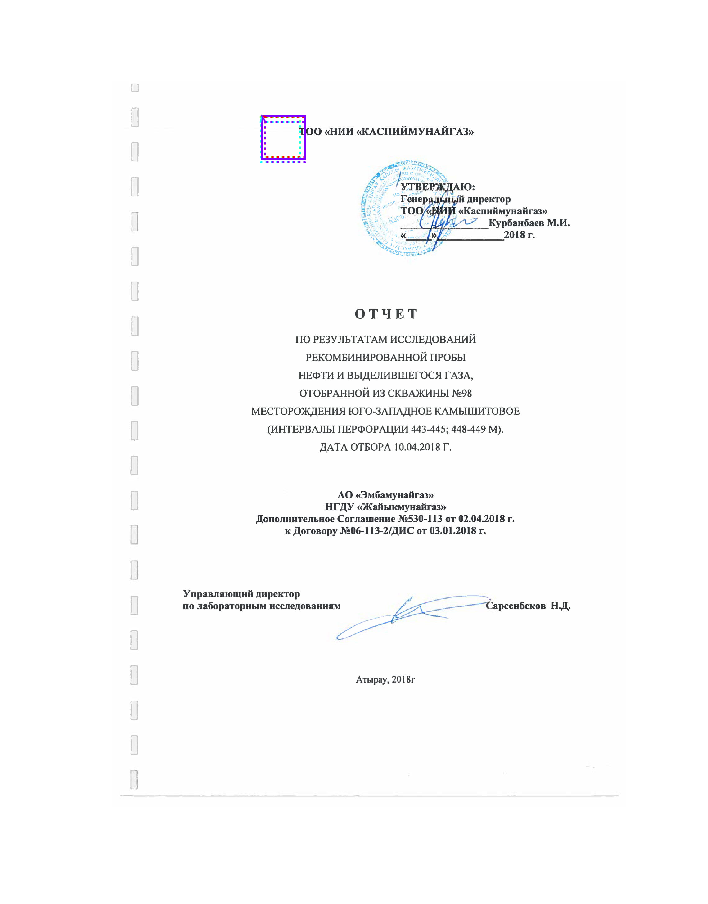

In [18]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [19]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35390  max:    1.29134  float32
refined_anchors          shape: (1, 6000, 4)          min:   -1.33848  max:    2.91320  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 5588.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


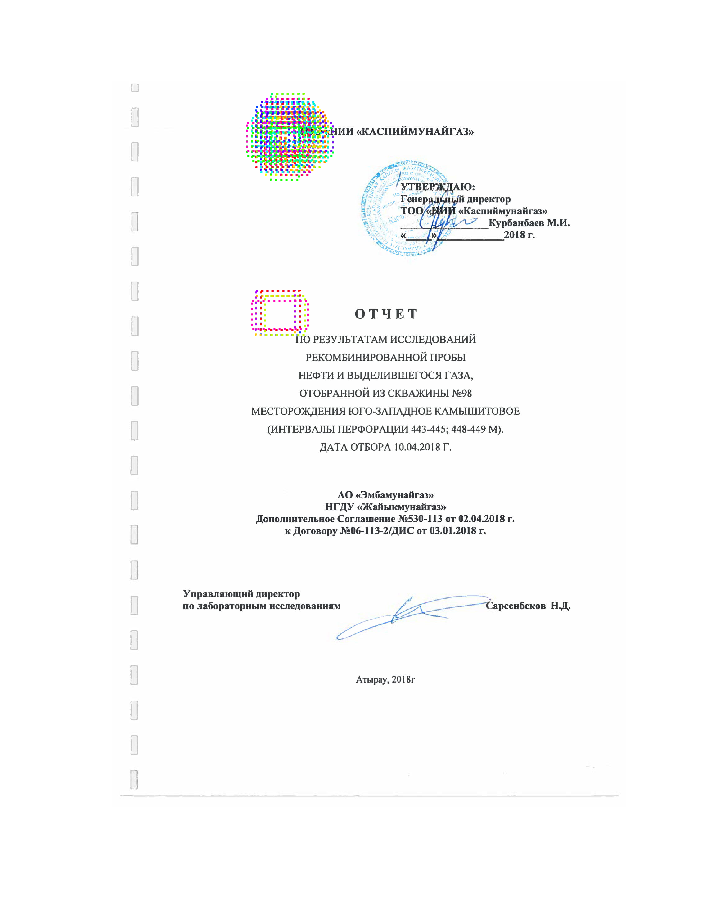

In [20]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

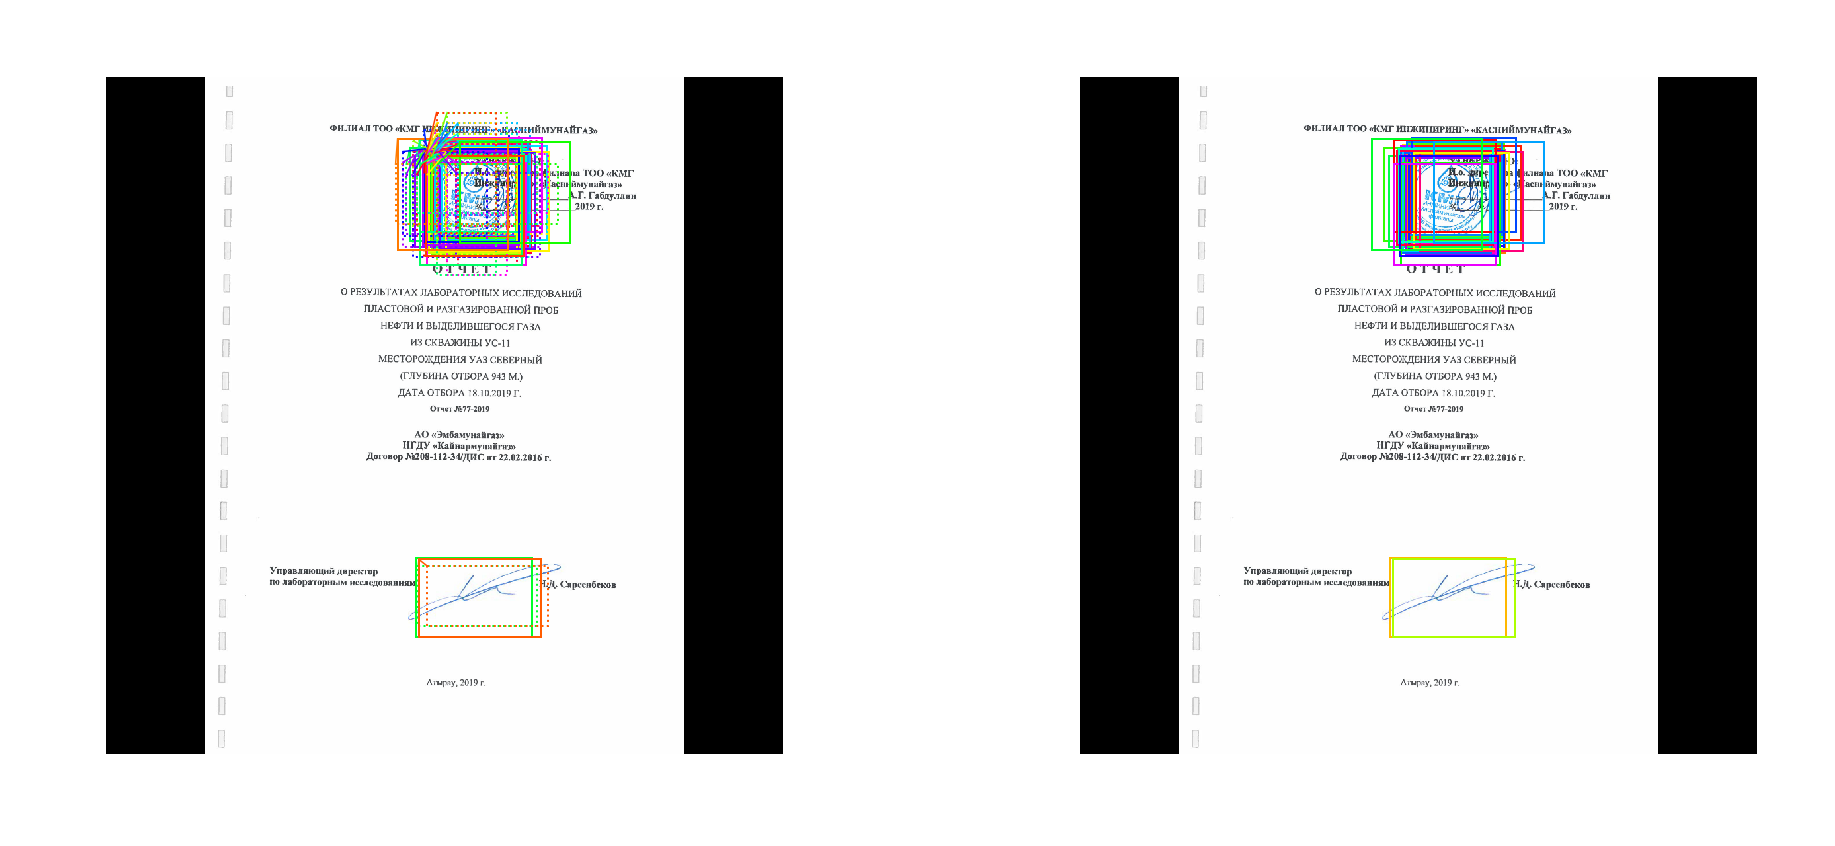

In [15]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

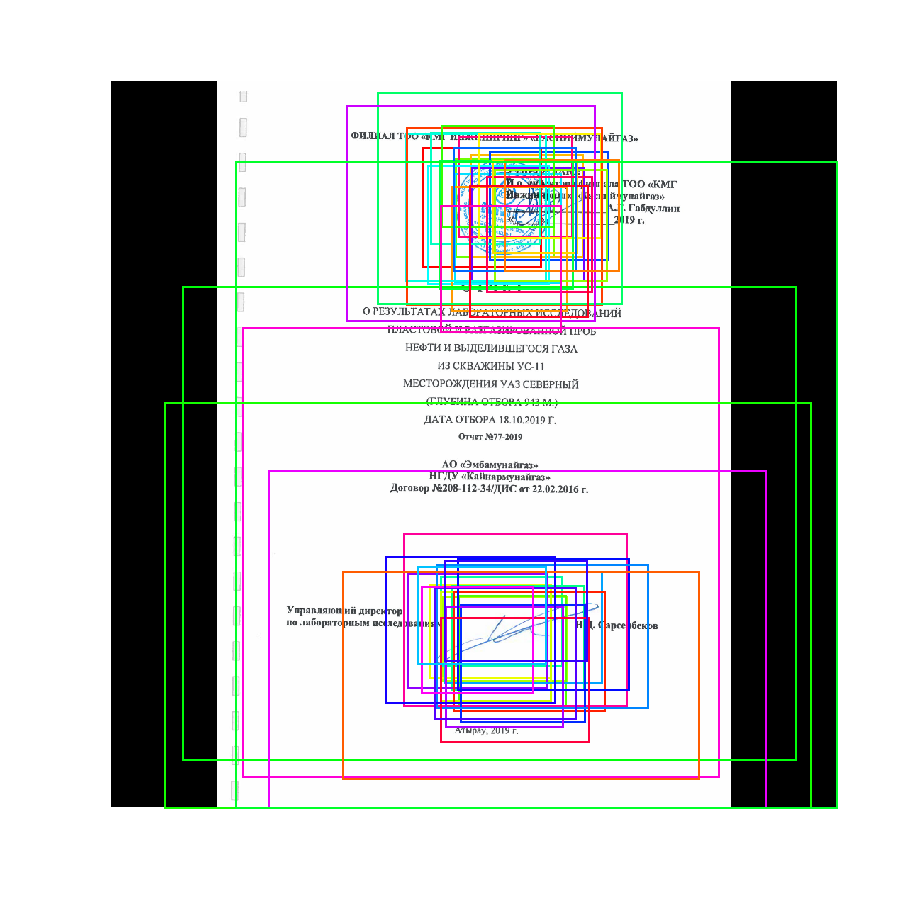

In [16]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

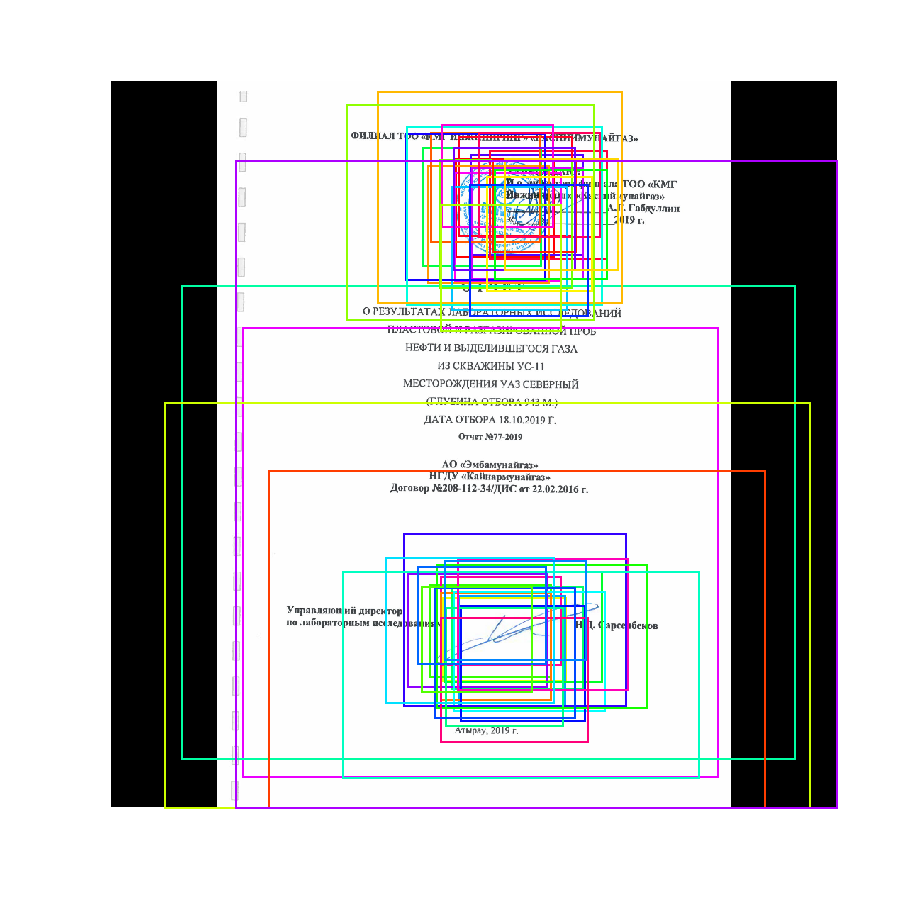

In [17]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [12]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -3.72915  max:    3.72865  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


1 detections: ['seal']


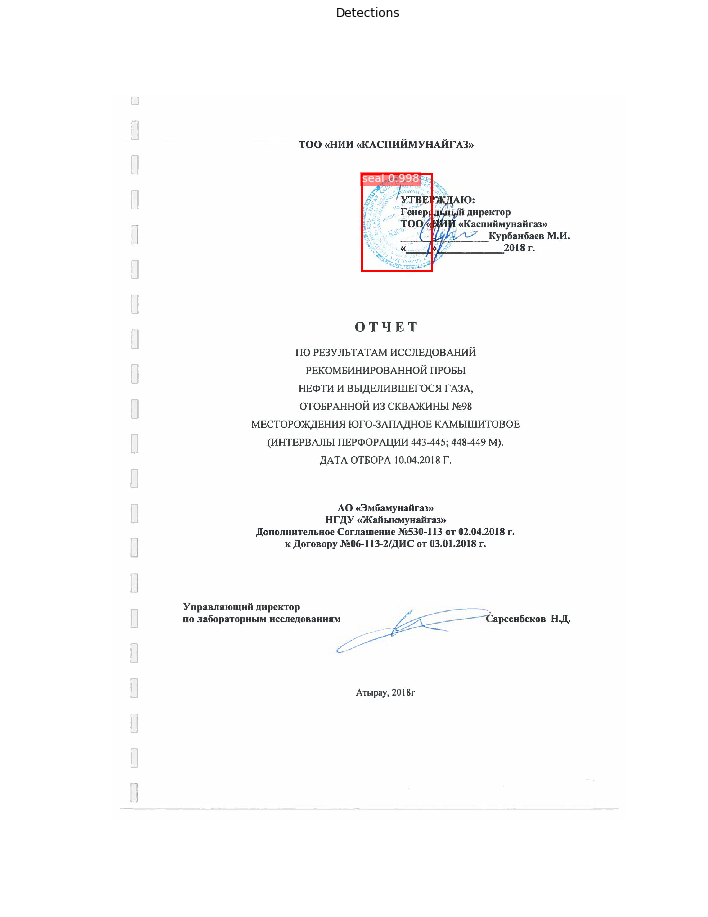

In [15]:
import matplotlib.image as mpimg
image=mpimg.imread('1-004.jpg')
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [20]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
15 Positive ROIs
[('BG', 985), ('seal', 15)]


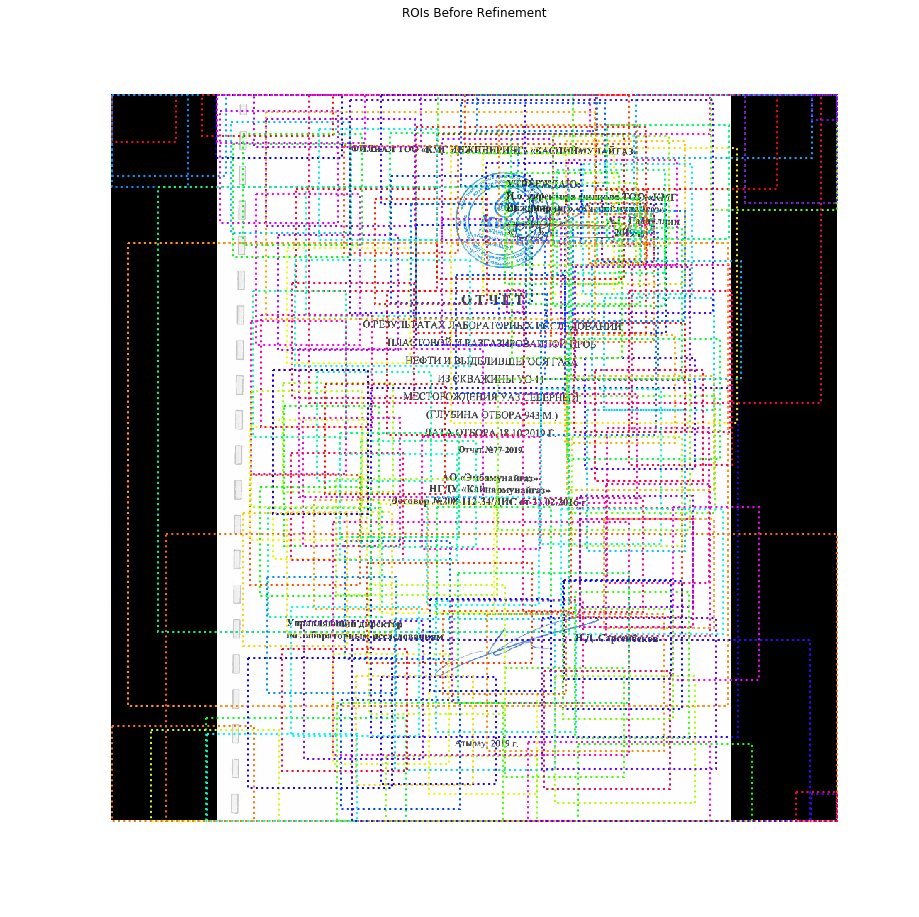

In [21]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -3.72794  max:    2.98081  float32
refined_proposals        shape: (1000, 4)             min:  -34.00000  max: 1018.00000  int32


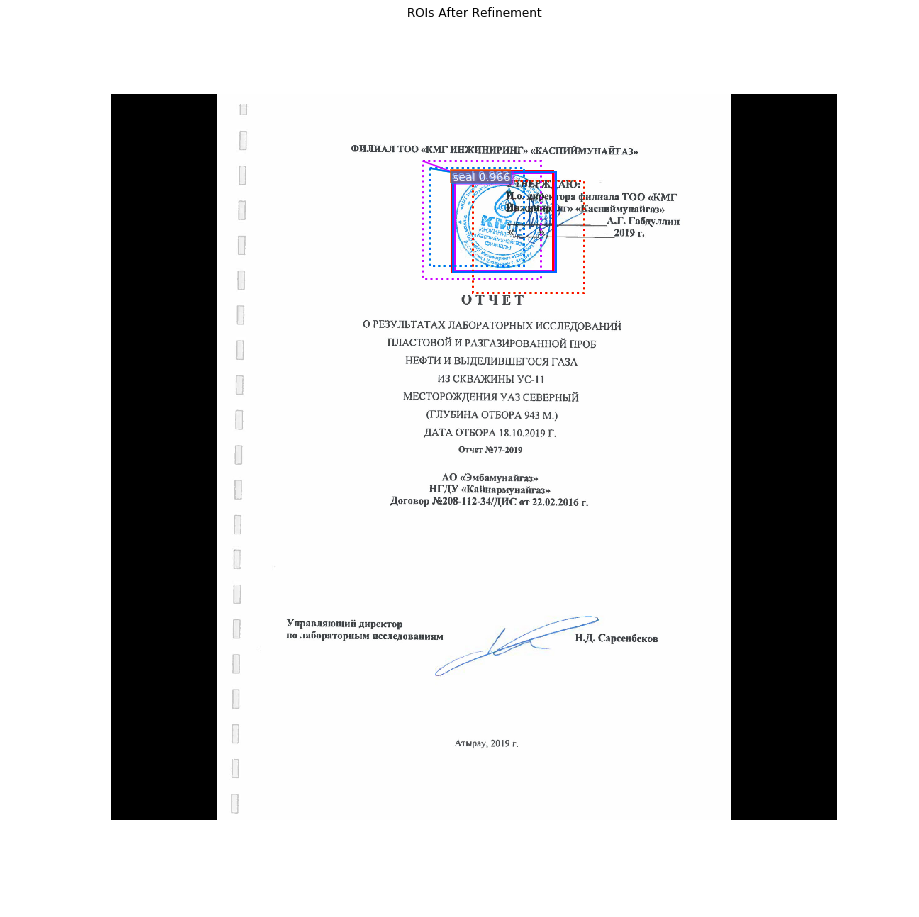

In [22]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [23]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 15 detections:
[  0   1   2   5   7   9  10  11  30  34  39 376 383 622 777]


In [24]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 12:
[  0   1   2   5   9  10  11  30  39 376 383 777]


#### Per-Class Non-Max Suppression

In [25]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

seal                  : [  0   1   2   5   9  10  11  30  39 376 383 777] -> [2]

Kept after per-class NMS: 1
[2]


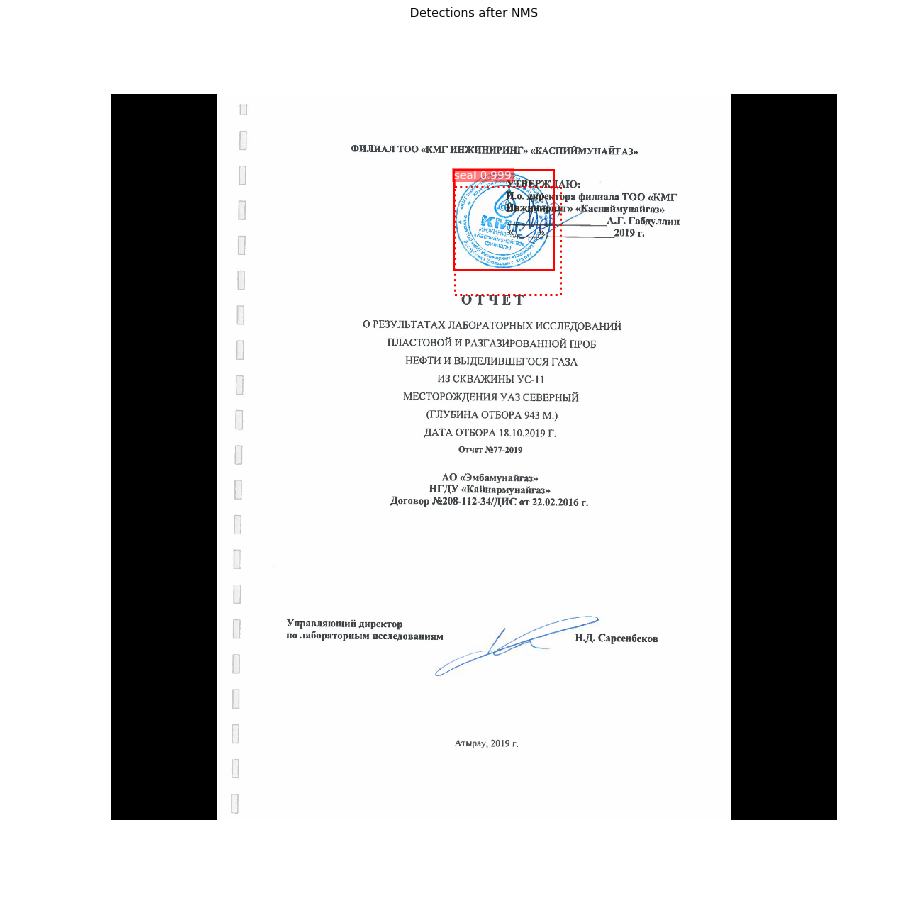

In [26]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

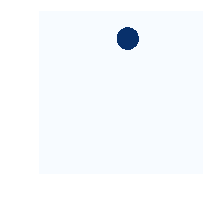

In [27]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [28]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
1 detections: ['seal']


In [29]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (1, 28, 28)           min:    0.00000  max:    1.00000  float32
det_masks                shape: (1, 1024, 1024)       min:    0.00000  max:    1.00000  bool


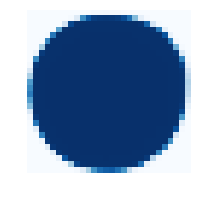

In [30]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

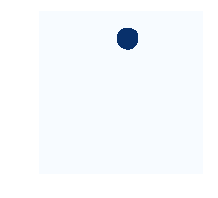

In [31]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [32]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   41.59982  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   37.84171  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   57.20252  float32
rpn_bbox                 shape: (1, 261888, 4)        min:   -5.19197  max:  132.76096  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


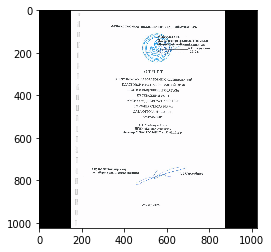

In [33]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

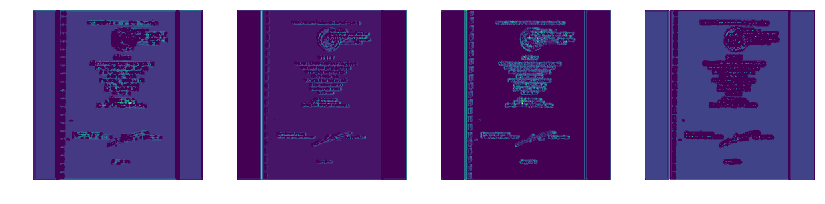

In [34]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

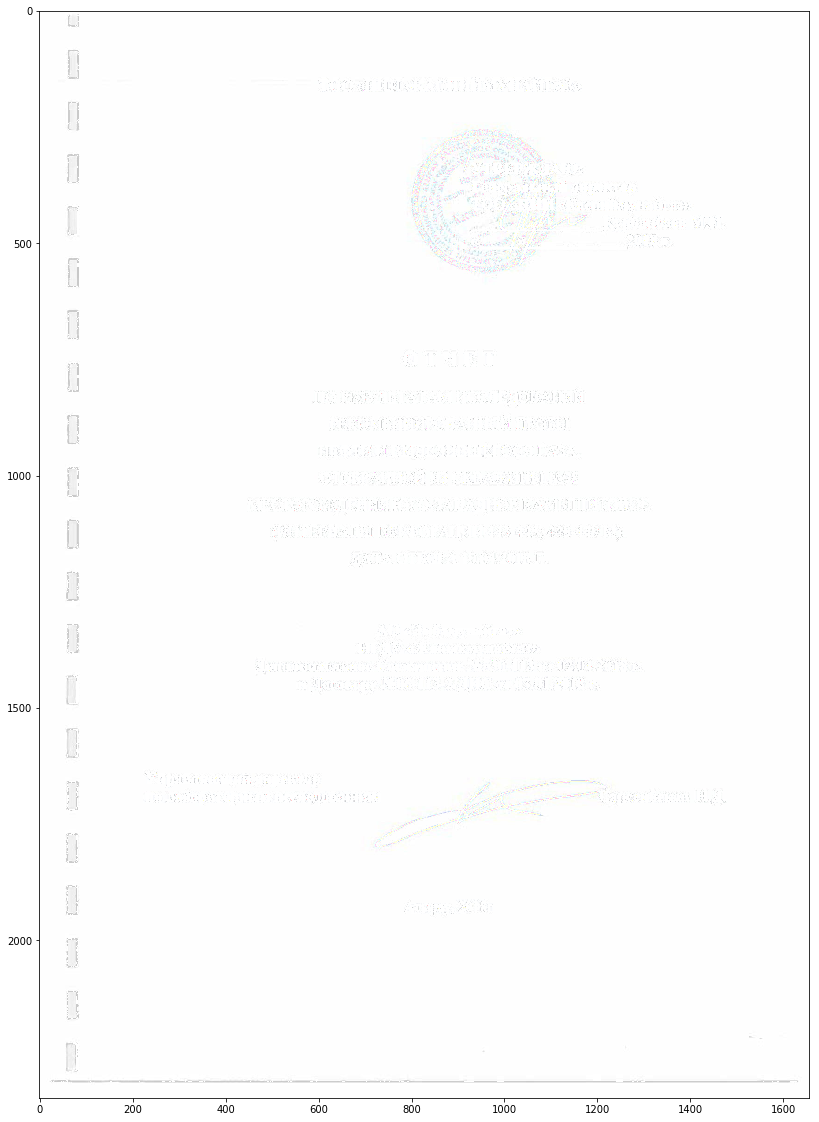

In [43]:
import cv2 
img = cv2.imread('1-004.jpg')
fig = plt.figure(figsize=(20,20))
img[img<200]=255
plt.imshow(img[:,:,::-1])

In [56]:
count=0
print(r['masks'].shape)
print(r['rois'])
masks = r['masks'][r['rois'][0][0]:r['rois'][0][2],r['rois'][0][1]:r['rois'][0][3]]
#print(masks)
print(len(masks[1]))
#r_masks = np.resize(masks,(100,100))
for i, el in enumerate(masks):
    for j, el2 in enumerate(el):
        if el2==True:
            #if count<20:
             #   print(i, j)
            count+=1
            
print(count)

(2339, 1656, 1)
[[ 253  800  566 1117]]
317
76613


In [24]:
masks = r['masks'][1240:1552,570:889]
#r_masks = np.resize(masks,(101,101))
#print(r_masks)
count=0
for i, el in enumerate(masks):
    
    for j, el2 in enumerate(el):
        if el2==False:
            count+=1

print(count)

25837


In [57]:
ideal_seal = np.zeros((masks.shape[0],masks.shape[1]),  dtype=bool)
ideal_seal = ideal_seal.reshape(masks.shape[0],masks.shape[1],masks.shape[2])
for i in range(len(ideal_seal)):
    for j in range(len(ideal_seal[i])):
        #print(np.sqrt(pow((5-i),2)+pow((5-j),2)))
        if np.sqrt(pow((len(masks[0])/2-i),2)+pow((len(masks[0])/2-j),2))<=len(masks[0])/2:
            ideal_seal[i][j]=True
#print(ideal_seal)

In [25]:
print(ideal_seal.shape)
count=0
for i, el in enumerate(ideal_seal):
    #if count<5:
    #    print(el)
    for j in el:
        if j==False:
            count+=1
print(count)

(312, 319, 1)
20106


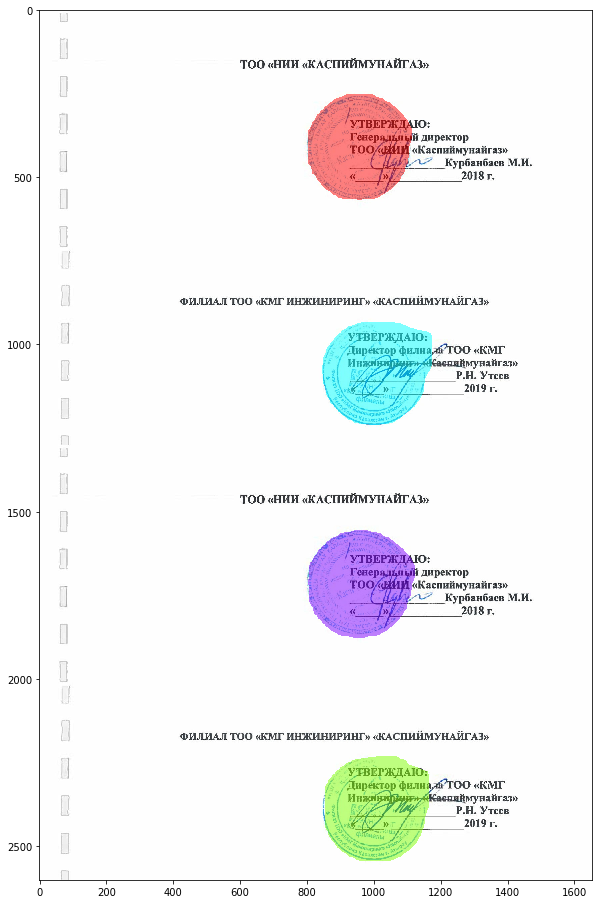

In [10]:
import random
import colorsys
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image
masks = r['masks']
boxes = r['rois']
colors=None
show_mask=True
ax=None
masked_image = image.astype(np.uint32).copy()
N = boxes.shape[0]
colors = colors or random_colors(N)
auto_show = False
if not ax:
    _, ax = plt.subplots(1, figsize=(16,16))
    auto_show = True
for i in range(N):
    color = colors[i]
    # Mask
    mask = masks[:, :, i]
    if show_mask:
        masked_image = apply_mask(masked_image, mask, color)
ax.imshow(masked_image.astype(np.uint8))
plt.show()

In [59]:
print(ideal_seal.shape)
print(masks.shape)
res = np.subtract(ideal_seal, masks, dtype=np.int)

count=0
for i, el in enumerate(res):
    for j in el:
        if j==0:
            count+=1
print(count)
print(res.shape)


(313, 317, 1)
(313, 317, 1)
97036
(313, 317, 1)


############################ PRODUCTION

In [25]:
masks = r['masks'][r['rois'][0][0]:r['rois'][0][2],r['rois'][0][1]:r['rois'][0][3]]
masks

array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]]])

In [ ]:
ideal_seal = np.zeros((masks.shape[0],masks.shape[1]),  dtype=bool)
ideal_seal = ideal_seal.reshape(masks.shape[0],masks.shape[1],masks.shape[2])
for i in range(len(ideal_seal)):
    for j in range(len(ideal_seal[i])):
        if np.sqrt(pow((len(masks[0])/2-i),2)+pow((len(masks[0])/2-j),2))<=len(masks[0])/2:
            ideal_seal[i][j]=True
#print(ideal_seal)

In [61]:
res = np.subtract(ideal_seal, masks, dtype=np.int)
count=0
for i, el in enumerate(res):
    for j in el:
        if j!=0:
            count+=1
print(count)



2185


In [62]:
shape_arr = masks.shape[0]*masks.shape[1]*masks.shape[2]
res_perc = count*100/shape_arr
res_perc


2.202154785781236

In [31]:
def delete_ele(masks):
    for i in masks:
        for j in i:
            del i[1]

In [24]:
def postChecking(masks, rois):
    masks = masks[rois[0]:rois[2],rois[1]:rois[3]]
    masks=masks.reshape(masks.shape[0], masks.shape[1], 1)
    ###################################################
    ideal_seal = np.zeros((masks.shape[0],masks.shape[1]),  dtype=bool)
    ideal_seal = ideal_seal.reshape(masks.shape[0],masks.shape[1],1)
    for i in range(len(ideal_seal)):
        for j in range(len(ideal_seal[i])):
            if np.sqrt(pow((len(masks[0])/2-i),2)+pow((len(masks[0])/2-j),2))<=len(masks[0])/2:
                ideal_seal[i][j]=True
    res = np.subtract(ideal_seal, masks, dtype=np.int)
    count=0
    for i, el in enumerate(res):
        for j in el:
            if j!=0:
                count+=1
    shape_arr = masks.shape[0]*masks.shape[1]*masks.shape[2]
    res_perc = count*100/shape_arr
    print(res_perc)
    if res_perc<15:
        return True
    else:
        return False

In [25]:
rois =r['rois']
masks = r['masks']
for i in range(masks.shape[2]):
    mask = masks[:, :, i]
    print(i)
    if (rois[i][3]-rois[i][1])/(rois[i][2]-rois[i][0])>0.9:
        print((rois[i][3]-rois[i][1])/(rois[i][2]-rois[i][0]))
        res = postChecking(mask, rois[i])
        print(res)

0
1.034934497816594
10.025242754224015
True
1
1.0066889632107023
4.613384593162146
True


In [16]:
print(r['masks'].shape)
print(r['rois'].shape)

(720, 1280, 2)
(2, 4)
